# Setup

In [395]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LeakyReLU, Activation, LSTM, SimpleRNN, Bidirectional
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import RMSprop
import json
import os
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import copy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import pandas as pd
import pickle

pd.set_option('display.max_rows', 200)

In [3]:
try:
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    print("TensorFlow is not installed")

try:
    import torch
    print(f"PyTorch version: {torch.__version__}")
except ImportError:
    print("PyTorch is not installed")

TensorFlow version: 2.12.0
PyTorch version: 2.2.2


# Load / prepare data

In [456]:
# Load 4 data files
data_dir = os.getcwd() + '/Data/'
augusta_data_fname = 'augusta,-georgia, usa-air-quality.csv'
buffalo_data_fname = 'buffalo,-new york, usa-air-quality.csv'
cincinnati_data_fname = 'cincinnati-near road, ohio, usa-air-quality.csv'
rockville_data_fanme = 'rockville,-maryland-air-quality.csv'

augusta_df = pd.read_csv(data_dir + augusta_data_fname)
buffalo_df = pd.read_csv(data_dir + buffalo_data_fname)
cincinnati_df = pd.read_csv(data_dir + cincinnati_data_fname)
rockville_df = pd.read_csv(data_dir + rockville_data_fanme)

print(augusta_df.shape, buffalo_df.shape, cincinnati_df.shape, rockville_df.shape)

(3996, 5) (3901, 5) (3689, 4) (3645, 3)


In [457]:
# Add suffix to columns names for identification
augusta_df.columns = augusta_df.columns.str.strip() + '_aug'
buffalo_df.columns = buffalo_df.columns.str.strip() + '_buf'
cincinnati_df.columns = cincinnati_df.columns.str.strip() + '_cin'
rockville_df.columns = rockville_df.columns.str.strip() + '_rock'

# Replace all empty strings with nans
augusta_df = augusta_df.replace(' ', np.nan)
buffalo_df = buffalo_df.replace(' ', np.nan)
cincinnati_df = cincinnati_df.replace(' ', np.nan)
rockville_df = rockville_df.replace(' ', np.nan)

In [458]:
# Variable of interest is pm25, PM 2.5
pm25_data = \
    pd.merge(
        pd.merge(
            pd.merge(augusta_df[['date_aug', 'pm25_aug']],
                     buffalo_df[['date_buf', 'pm25_buf']], how = 'inner', left_on = 'date_aug', right_on = 'date_buf'
                    ),
            cincinnati_df[['date_cin', 'pm25_cin']], how = 'inner', left_on = 'date_aug', right_on = 'date_cin'
        ),
        rockville_df[['date_rock', 'pm25_rock']], how = 'inner', left_on = 'date_aug', right_on = 'date_rock'
    )

pm25 = pm25_data.drop(['date_buf', 'date_cin', 'date_rock'], axis = 1)
pm25 = pm25.sort_values('date_aug', ascending = False)
pm25 = pm25.rename(columns = {'date_aug': 'date'})
pm25 = pm25.dropna(how = 'all') # only drop a row if all data is missing
pm25.loc[:, 'date'] = pd.DatetimeIndex(pm25['date']) # convert date to datetime
pm25.shape

(3578, 5)

In [459]:
# Calculation for totally missing days
test = pm25[pd.DatetimeIndex(pm25['date']) > '2017-01-04'].copy()

start_date = test['date'].min()
end_date = test['date'].max()
complete_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# All missing values count
((complete_dates.difference(test['date']).shape[0] * 4) + (test.isna().sum().sum(axis = 0))) / (len(complete_dates) * 4)

0.03063274188148644

In [460]:
# Add days with missing values to datafame
start_date = pm25['date'].min()
end_date = pm25['date'].max()
complete_dates = pd.date_range(start=start_date, end=end_date, freq='D')

pm25 = pm25.set_index('date').reindex(complete_dates).ffill()

In [461]:
# Filter to 2017 onward (exclude before jan 4 since cin started then)
pm25 = pm25[pm25.index >= '2017-01-04'].copy()
pm25 = pm25.astype(int)
pm25.shape

(2988, 4)

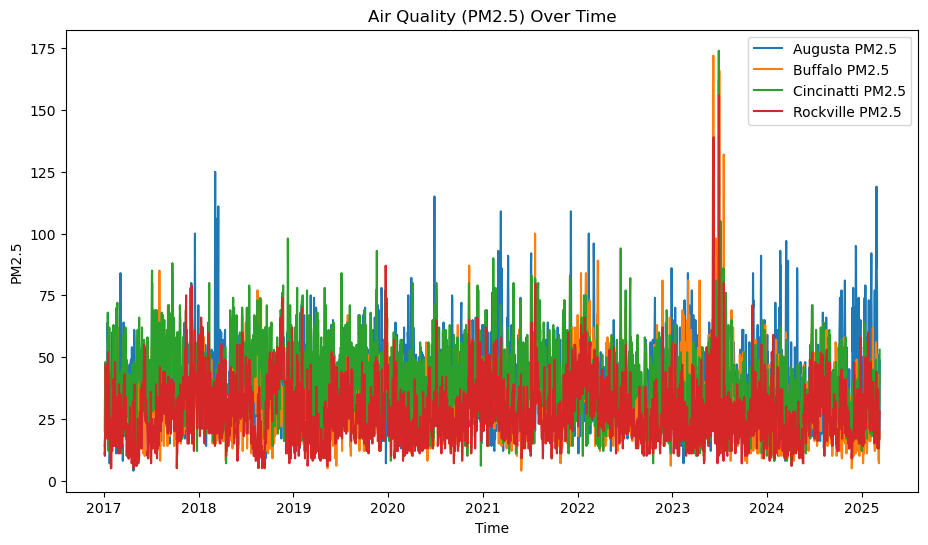

In [462]:
plt.figure(figsize=(11, 6))
plt.plot(pm25.index, pm25['pm25_aug'], label = 'Augusta PM2.5')
plt.plot(pm25.index, pm25['pm25_buf'], label = 'Buffalo PM2.5')
plt.plot(pm25.index, pm25['pm25_cin'], label = 'Cincinatti PM2.5')
plt.plot(pm25.index, pm25['pm25_rock'], label = 'Rockville PM2.5')



plt.title('Air Quality (PM2.5) Over Time')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Rockville PM2.5 Levels')

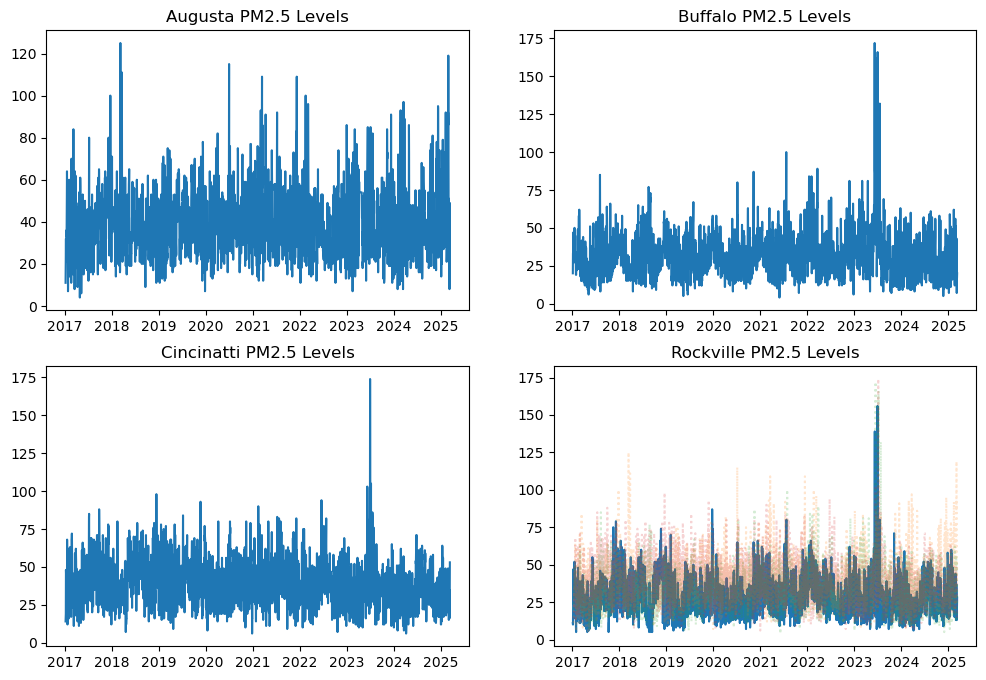

In [463]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
ax[0, 0].plot(pm25.index, pm25['pm25_aug'])
ax[0, 0].set_title('Augusta PM2.5 Levels')
ax[0, 1].plot(pm25.index, pm25['pm25_buf'])
ax[0, 1].set_title('Buffalo PM2.5 Levels')
ax[1, 0].plot(pm25.index, pm25['pm25_cin'])
ax[1, 0].set_title('Cincinatti PM2.5 Levels')
ax[1, 1].plot(pm25.index, pm25['pm25_rock'], label = 'Rockville PM2.5')
ax[1, 1].plot(pm25.index, pm25['pm25_aug'].shift(7), label = 'Augusta PM2.5 7 day lag', alpha = .2, ls = ':')
ax[1, 1].plot(pm25.index, pm25['pm25_buf'].shift(7), label = 'Buffalo PM2.5 7 day lag', alpha = .2, ls = ':')
ax[1, 1].plot(pm25.index, pm25['pm25_cin'].shift(7), label = 'Cincinatti PM2.5 7 day lag', alpha = .2, ls = ':')
ax[1, 1].set_title('Rockville PM2.5 Levels')

In [464]:
# Correlation matrix
corr1 = pd.DataFrame(pm25['pm25_rock'])
corr1.columns = ['pm25_rock_current']
corr2 = pm25.shift(7).copy()
corr2.columns = corr2.columns + '_lagged_7d'
corr_analysis = pd.concat([corr1, corr2], axis = 1)
corr_analysis.corr()

,pm25_rock_current,pm25_aug_lagged_7d,pm25_buf_lagged_7d,pm25_cin_lagged_7d,pm25_rock_lagged_7d
pm25_rock_current,1.000000,0.026765,0.044737,0.010044,0.217038
pm25_aug_lagged_7d,0.026765,1.000000,0.203473,0.244380,0.273819
pm25_buf_lagged_7d,0.044737,0.203473,1.000000,0.488385,0.485833
pm25_cin_lagged_7d,0.010044,0.244380,0.488385,1.000000,0.414380
pm25_rock_lagged_7d,0.217038,0.273819,0.485833,0.414380,1.000000


In [465]:
# Get differences in air quality for each area
pm25_diff = pm25.copy().diff().dropna()
df = pm25.copy()
assert pm25.equals(df)

# Prepare Data with Lags for modeling (just lagged target to start)

In [466]:
def prepare_data(df, lags, lookback, lag_var_cols, target_col):
    """
    Args:
        df (pd.DataFrame): time series data
        lags (list of int): A list of lag periods to create lagged features
        lookback (int): The number of past observations to include in each trailing window.
        lag_var_cols (list of str): Name of the columns in the DataFrame to create lagged variables with
        target_col (str): The name of the column in the DataFrame to use as the target variable (e.g., 'Price').

   Returns:
        X_train (np.ndarray): A 3D array of shape (samples, lookback, len(lags)), where:
                              - samples is the number of trailing windows.
                              - lookback is the number of time steps in each window.
                              - len(lags) is the number of lagged features.
        y_train (np.ndarray): A 1D array of target values of shape `(samples, 1)`

    """
    data = copy.deepcopy(df)
    for lag in lags:
        for lag_var_col in lag_var_cols:
            data[f'{lag_var_col}_lag_{lag}'] = data[lag_var_col].shift(lag)
    
    data = data.dropna()
    
    windows = []
    y_vals = []
    X_mat_cols = []
    for lag in lags:
        for lag_var_col in lag_var_cols:
            X_mat_cols.append(f'{lag_var_col}_lag_{lag}')
    X_mat = data[[col for col in X_mat_cols]].copy().values
    
    for i in range(lookback, len(X_mat)+1):
        window = X_mat[i - lookback:i, :]  # Extract a 60-day trailing window
        windows.append(window)
        y_val = data.iloc[i-1][target_col]
        y_vals.append(y_val)
    
    X_train = np.array(windows)
    y_train = np.array(y_vals).reshape(-1, 1)
    print(X_train.shape, y_train.shape)

    return X_train, y_train, data

In [467]:
# Parameters for generating the data
target_col = 'pm25_rock'
lag_var_cols = ['pm25_rock_scaled'] #['pm25_aug', 'pm25_buf', 'pm25_cin']
lookback = 60
lags = [7, 14, 21]

In [468]:
# Split dataframe into train / test
train_df = df[df.index <= '2023-01-01'].copy()
test_df = df[df.index > '2023-01-01'].copy()
print(train_df.shape, test_df.shape)

(2189, 4) (799, 4)


In [471]:
# Train / test split
print(train_df.shape[0] / df.shape[0])

0.7325970548862115

In [350]:
# Add min / max scaling of input variables to dataframes
sc_rock = MinMaxScaler(feature_range = (0, 1))
train_target_scaled_rock = sc_rock.fit_transform(train_df['pm25_rock'].values.reshape(train_df.shape[0], 1))
test_target_scaled_rock = sc_rock.transform(test_df['pm25_rock'].values.reshape(test_df.shape[0], 1))

train_df.loc[:, 'pm25_rock_scaled'] = train_target_scaled_rock
test_df.loc[:, 'pm25_rock_scaled'] = test_target_scaled_rock

# Augusta
sc_aug = MinMaxScaler(feature_range = (0, 1))
train_target_scaled_aug = sc_aug.fit_transform(train_df['pm25_aug'].values.reshape(train_df.shape[0], 1))
test_target_scaled_aug = sc_aug.transform(test_df['pm25_aug'].values.reshape(test_df.shape[0], 1))

train_df.loc[:, 'pm25_aug_scaled'] = train_target_scaled_aug
test_df.loc[:, 'pm25_aug_scaled'] = test_target_scaled_aug

# Buffalo
sc_buf = MinMaxScaler(feature_range = (0, 1))
train_target_scaled_buf = sc_buf.fit_transform(train_df['pm25_buf'].values.reshape(train_df.shape[0], 1))
test_target_scaled_buf = sc_buf.transform(test_df['pm25_buf'].values.reshape(test_df.shape[0], 1))

train_df.loc[:, 'pm25_buf_scaled'] = train_target_scaled_buf
test_df.loc[:, 'pm25_buf_scaled'] = test_target_scaled_buf

# Cincinnati
sc_cin = MinMaxScaler(feature_range = (0, 1))
train_target_scaled_cin = sc_cin.fit_transform(train_df['pm25_cin'].values.reshape(train_df.shape[0], 1))
test_target_scaled_cin = sc_cin.transform(test_df['pm25_cin'].values.reshape(test_df.shape[0], 1))

train_df.loc[:, 'pm25_cin_scaled'] = train_target_scaled_cin
test_df.loc[:, 'pm25_cin_scaled'] = test_target_scaled_cin

In [354]:
# Generate the data
X_train, y_train, data_train = prepare_data(train_df, lags = lags, lookback = lookback,
                                            lag_var_cols = lag_var_cols, target_col = target_col)
X_test, y_test, data_test = prepare_data(test_df, lags = lags, lookback = lookback, 
                                         lag_var_cols = lag_var_cols, target_col = target_col)

(2109, 60, 3) (2109, 1)
(719, 60, 3) (719, 1)


# Train Models

In [367]:
def create_lstm_model(unit_list, dropout_rate_list, input_shape):

    # Check that both list are equal length
    assert isinstance(unit_list, list)
    assert isinstance(unit_list, list)
    assert len(unit_list) == len(dropout_rate_list)

    model = Sequential()
    for ii in range(len(unit_list)):

        dropout = dropout_rate_list[ii]
        unit = unit_list[ii]
        
        if ii == 0:
            model.add(LSTM(units = unit, return_sequences = True, input_shape = input_shape))
            if dropout > 0:
                model.add(Dropout(dropout))

        # If we aren't on the last node, still use return sequences
        elif ii != len(unit_list)-1:
            model.add(LSTM(units = unit, return_sequences = True))
            if dropout > 0:
                model.add(Dropout(dropout))

        else:
            model.add(LSTM(units = unit))
            if dropout > 0:
                model.add(Dropout(dropout))

    # Add output layer
    model.add(Dense(units = 1, activation = 'linear'))

    return model


def train_lstm_model(model, X_train, y_train, epochs, batch_size, loss):

    # Compiling the LSTM
    model.compile(optimizer = 'adam', loss = loss)
    
    # Fitting the LSTM to the Training set
    history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

    return model, history



def create_simple_rnn_model(unit_list, dropout_rate_list, output_shape, activation):

    # Check that both list are equal length
    assert isinstance(unit_list, list)
    assert isinstance(unit_list, list)
    assert len(unit_list) == len(dropout_rate_list)

    # If activation function is leakyRELU, modify it to pass directly to simpleRNN unit
    if activation == 'LeakyReLU':
        activation = tf.keras.layers.LeakyReLU(alpha=0.2)
    
    model = Sequential()
    for ii in range(len(unit_list)):
    
        units = unit_list[ii]
        dropout = dropout_rate_list[ii]

        if ii == 0:
            model.add(SimpleRNN(units = units, input_shape=input_shape, 
                                activation=activation, return_sequences = True))

        elif ii != len(unit_list)-1:
            model.add(SimpleRNN(units = units, activation = activation,
                                return_sequences = True))
            if dropout > 0:
                model.add(Dropout(dropout))

        else:
            model.add(SimpleRNN(units, activation = activation))

        if dropout > 0:
            model.add(Dropout(dropout))

    # Add output layer
    model.add(Dense(units = 1, activation = activation))
            
    return model

def train_simple_rnn_model(model, X_train, y_train, epochs, batch_size, loss):

    model.compile(optimizer = 'adam', loss = loss)

    history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

    return model, history

### Simple RNNs with just 1 lag feature

In [295]:
# Not going to test the number of epochs
epochs = 100

data_and_model_configs = [
    {'unit_list': [10] * 4, 'dropout_rate_list': [0] * 4, 'lags': [7, 14, 21], 'lookback': 60, 'batch_size': 32, 
         'activation': 'LeakyReLU', 'loss': 'mean_squared_error', 'label': '4 layers, no dropout, batch size 32, LeakyReLU, MSE'},
    {'unit_list': [10] * 4, 'dropout_rate_list': [0] * 4, 'lags': [7, 14, 21], 'lookback': 60, 'batch_size': 32,
         'activation': 'linear', 'loss': 'mean_squared_error', 'label': '4 layers, no dropout, batch size 32, Linear Activation, MSE'},
    {'unit_list': [10] * 4, 'dropout_rate_list': [0] * 4, 'lags': [7, 14, 21], 'lookback': 60, 'batch_size': 32,
         'activation': 'linear', 'loss': 'mean_absolute_error', 'label': '4 layers, no dropout, batch size 32, Linear Activation, MAE'},
    {'unit_list': [10] * 6, 'dropout_rate_list': [.2] * 6, 'lags': [7, 14, 21], 'lookback': 60, 'batch_size': 32,
         'activation': 'linear', 'loss': 'mean_squared_error', 'label': '6 layers, 20% dropout, batch size 32, Linear Activation, MSE'},
    {'unit_list': [10] * 3, 'dropout_rate_list': [.2] * 3, 'lags': [7, 14, 21], 'lookback': 60, 'batch_size': 32,
         'activation': 'linear', 'loss': 'mean_squared_error', 'label': '3 layers, 20% dropout, batch size 32, Linear Activation, MSE'},
]

In [296]:
# Get model output (let's not play with lookback / lags in this)
models = []

for config in data_and_model_configs:

    lags = config['lags']
    lookback = config['lookback']
    unit_list = config['unit_list']
    dropout_rate_list = config['dropout_rate_list']
    batch_size = config['batch_size']
    activation = config['activation']
    
    # Get input shape to pass to LSTM object
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Create and train lstm model
    model = create_simple_rnn_model(unit_list, dropout_rate_list, input_shape, activation)
    model, history = train_simple_rnn_model(model, X_train, y_train, epochs, batch_size)
    
    # Save model and data
    models.append(model)

Epoch 1/100
66/66 [==============================] - 1s 10ms/step - loss: 457.6796
Epoch 2/100
66/66 [==============================] - 1s 10ms/step - loss: 173.1431
Epoch 3/100
66/66 [==============================] - 1s 11ms/step - loss: 173.1122
Epoch 4/100
66/66 [==============================] - 1s 10ms/step - loss: 159.2253
Epoch 5/100
66/66 [==============================] - 1s 10ms/step - loss: 154.3521
Epoch 6/100
66/66 [==============================] - 1s 10ms/step - loss: 153.8688
Epoch 7/100
66/66 [==============================] - 1s 10ms/step - loss: 153.8354
Epoch 8/100
66/66 [==============================] - 1s 10ms/step - loss: 148.6071
Epoch 9/100
66/66 [==============================] - 1s 10ms/step - loss: 147.2081
Epoch 10/100
66/66 [==============================] - 1s 10ms/step - loss: 145.4535
Epoch 11/100
66/66 [==============================] - 1s 11ms/step - loss: 144.0334
Epoch 12/100
66/66 [==============================] - 1s 10ms/step - loss: 144.8612
E

66/66 [==============================] - 0s 2ms/step


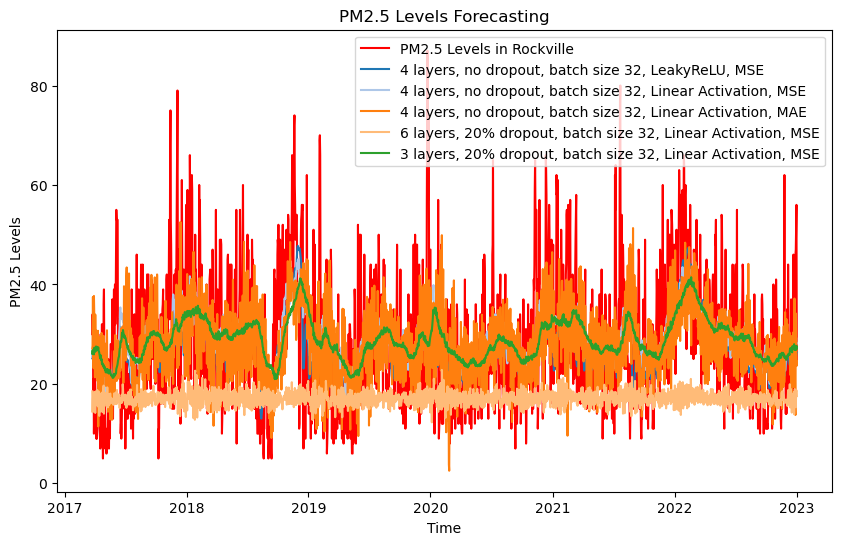

In [300]:
# Visualize train performance data
plt.figure(figsize=(10, 6))
plt.plot(train_df.tail(y_train.shape[0]).index, train_df.tail(y_train.shape[0])[target_col], color = 'red', label = 'PM2.5 Levels in Rockville')

for ii in range(len(models)):
    color = plt.cm.tab20(ii)
    model = models[ii]
    label = data_and_model_configs[ii]['label']
    #y_train = data_dicts[ii]['y_train']
    #X_train = data_dicts[ii]['X_train']
    plt.plot(train_df.tail(y_train.shape[0]).index, model.predict(X_train), # sc.inverse_transform(model.predict(X_train)), 
             color = color, label = label)
    
plt.title('PM2.5 Levels Forecasting')
plt.xlabel('Time')
plt.ylabel('PM2.5 Levels')
plt.legend()
plt.show()

23/23 [==============================] - 0s 2ms/step


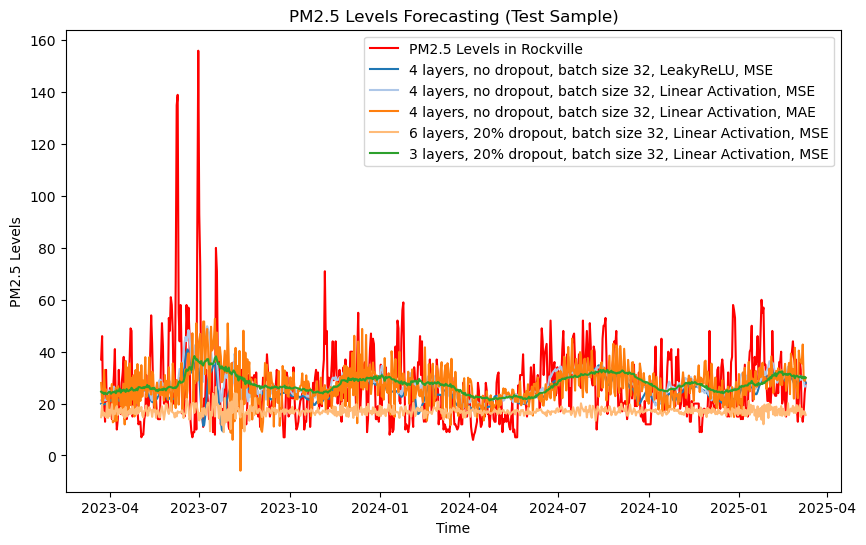

In [339]:
# Visualize test performance data
plt.figure(figsize=(10, 6))
plt.plot(test_df.tail(y_test.shape[0]).index, test_df.tail(y_test.shape[0])[target_col], color = 'red', label = 'PM2.5 Levels in Rockville')

for ii in range(len(models)):
    color = plt.cm.tab20(ii)
    model = models[ii]
    label = data_and_model_configs[ii]['label']
    y_test = data_dict['y_test']
    X_test = data_dict['X_test']
    plt.plot(test_df.tail(y_test.shape[0]).index, model.predict(X_test), # sc.inverse_transform(model.predict(X_test)), 
             color = color, label = label)
    
plt.title('PM2.5 Levels Forecasting (Test Sample)')
plt.xlabel('Time')
plt.ylabel('PM2.5 Levels')
plt.legend()
plt.show()

In [347]:
# Test set performance comparison, not moving the needle much
mses = []
maes = []
model_types = []
for ii in range(len(models)):
    model = models[ii]
    label = data_and_model_configs[ii]['label']
    mses.append(mean_squared_error(y_true = y_test, y_pred = model.predict(X_test)))
    maes.append(mean_absolute_error(y_true = y_test, y_pred = model.predict(X_test)))
    model_types.append(label)
    print(label)

pd.DataFrame({'models': model_types}) #'MSE': mses, 'MAE': maes})

23/23 [==============================] - 0s 2ms/step
4 layers, no dropout, batch size 32, LeakyReLU, MSE
23/23 [==============================] - 0s 2ms/step
4 layers, no dropout, batch size 32, Linear Activation, MSE
23/23 [==============================] - 0s 2ms/step
4 layers, no dropout, batch size 32, Linear Activation, MAE
23/23 [==============================] - 0s 3ms/step
6 layers, 20% dropout, batch size 32, Linear Activation, MSE
23/23 [==============================] - 0s 2ms/step
3 layers, 20% dropout, batch size 32, Linear Activation, MSE


,models
0,"4 layers, no dropout, batch size 32, LeakyReLU..."
1,"4 layers, no dropout, batch size 32, Linear Ac..."
2,"4 layers, no dropout, batch size 32, Linear Ac..."
3,"6 layers, 20% dropout, batch size 32, Linear A..."
4,"3 layers, 20% dropout, batch size 32, Linear A..."


### Simple RNNs with lagged features from other states

In [355]:
# Parameters for generating the data
target_col = 'pm25_rock'
lag_var_cols = ['pm25_rock_scaled', 'pm25_aug_scaled', 'pm25_buf_scaled', 'pm25_cin_scaled']
lookback = 60
lags = [7, 14, 21]

In [356]:
# Generate the data
X_train2, y_train2, data_train2 = prepare_data(train_df, lags = lags, lookback = lookback,
                                            lag_var_cols = lag_var_cols, target_col = target_col)
X_test2, y_test2, data_test2 = prepare_data(test_df, lags = lags, lookback = lookback, 
                                         lag_var_cols = lag_var_cols, target_col = target_col)

(2109, 60, 12) (2109, 1)
(719, 60, 12) (719, 1)


In [361]:
# Not going to test the number of epochs
epochs = 200

data_and_model_configs = [
    {'unit_list': [10] * 4, 'dropout_rate_list': [0] * 4, 'lags': [7, 14, 21], 'lookback': 60, 'batch_size': 32, 
         'activation': 'LeakyReLU', 'loss': 'mean_squared_error', 'label': '4 layers, no dropout, batch size 32, LeakyReLU, 10 units'},
    {'unit_list': [20] * 4, 'dropout_rate_list': [0] * 4, 'lags': [7, 14, 21], 'lookback': 60, 'batch_size': 32, 
         'activation': 'LeakyReLU', 'loss': 'mean_squared_error', 'label': '4 layers, no dropout, batch size 32, LeakyReLU, 20 units'},
]

In [360]:
# Get model output (let's not play with lookback / lags in this)
models = []

for config in data_and_model_configs:

    lags = config['lags']
    lookback = config['lookback']
    unit_list = config['unit_list']
    dropout_rate_list = config['dropout_rate_list']
    batch_size = config['batch_size']
    activation = config['activation']
    loss = config['loss']fa
    
    # Get input shape to pass to LSTM object
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Create and train lstm model
    model = create_simple_rnn_model(unit_list, dropout_rate_list, input_shape, activation)
    model, history = train_simple_rnn_model(model, X_train, y_train, epochs, batch_size)
    
    # Save model and data
    models.append(model)

Epoch 1/200
66/66 [==============================] - 1s 10ms/step - loss: 977.0117
Epoch 2/200
66/66 [==============================] - 1s 10ms/step - loss: 927.6641
Epoch 3/200
66/66 [==============================] - 1s 10ms/step - loss: 192.8466
Epoch 4/200
66/66 [==============================] - 1s 10ms/step - loss: 162.1690
Epoch 5/200
66/66 [==============================] - 1s 10ms/step - loss: 157.7475
Epoch 6/200
66/66 [==============================] - 1s 10ms/step - loss: 157.3048
Epoch 7/200
66/66 [==============================] - 1s 10ms/step - loss: 156.1427
Epoch 8/200
66/66 [==============================] - 1s 10ms/step - loss: 152.9442
Epoch 9/200
66/66 [==============================] - 1s 10ms/step - loss: 156.5885
Epoch 10/200
66/66 [==============================] - 1s 10ms/step - loss: 156.2992
Epoch 11/200
66/66 [==============================] - 1s 10ms/step - loss: 154.3772
Epoch 12/200
66/66 [==============================] - 1s 11ms/step - loss: 151.9729
E

23/23 [==============================] - 0s 3ms/step


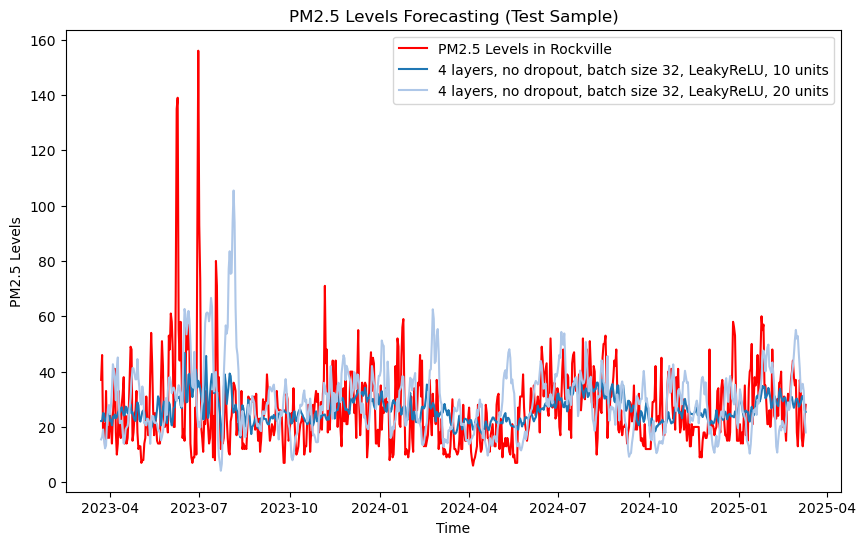

In [362]:
# Visualize test performance data
plt.figure(figsize=(10, 6))
plt.plot(test_df.tail(y_test.shape[0]).index, test_df.tail(y_test.shape[0])[target_col], color = 'red', label = 'PM2.5 Levels in Rockville')

for ii in range(len(models)):
    color = plt.cm.tab20(ii)
    model = models[ii]
    label = data_and_model_configs[ii]['label']
    y_test = data_dict['y_test']
    X_test = data_dict['X_test']
    plt.plot(test_df.tail(y_test.shape[0]).index, model.predict(X_test), # sc.inverse_transform(model.predict(X_test)), 
             color = color, label = label)
    
plt.title('PM2.5 Levels Forecasting (Test Sample)')
plt.xlabel('Time')
plt.ylabel('PM2.5 Levels')
plt.legend()
plt.show()

In [365]:
# Test set performance comparison, not moving the needle much
train_mses = []
test_mses = []
model_types = []
for ii in range(len(models)):
    model = models[ii]
    label = data_and_model_configs[ii]['label']
    train_mses.append(mean_squared_error(y_true = y_train, y_pred = model.predict(X_train)))
    test_mses.append(mean_squared_error(y_true = y_test, y_pred = model.predict(X_test)))
    model_types.append(label)
    print(label)

pd.DataFrame({'models': model_types, 'Train MSE': train_mses, 'Test MSE': test_mses})

23/23 [==============================] - 0s 2ms/step
4 layers, no dropout, batch size 32, LeakyReLU, 10 units
23/23 [==============================] - 0s 3ms/step
4 layers, no dropout, batch size 32, LeakyReLU, 20 units


,models,Train MSE,Test MSE
0,"4 layers, no dropout, batch size 32, LeakyReLU...",129.888644,200.976433
1,"4 layers, no dropout, batch size 32, LeakyReLU...",57.657252,338.956257


### LSTM with lagged features

In [387]:
# Not going to test the number of epochs
epochs = 200

data_and_model_configs = [
    {'unit_list': [10] * 4, 'dropout_rate_list': [0] * 4, 'lags': [7, 14, 21], 'lookback': 60, 'batch_size': 32, 
         'loss': 'mean_squared_error', 'label': '4 layers, no dropout, batch size 32, 10 units'},
    {'unit_list': [20] * 4, 'dropout_rate_list': [.2] * 4, 'lags': [7, 14, 21], 'lookback': 60, 'batch_size': 32, 
         'loss': 'mean_squared_error', 'label': '4 layers, 20% dropout, batch size 32, 20 units'},
    {'unit_list': [20] * 4, 'dropout_rate_list': [.1] * 4, 'lags': [7, 14, 21], 'lookback': 60, 'batch_size': 32, 
         'loss': 'mean_squared_error', 'label': '4 layers, 10% dropout, batch size 32, 20 units'},
]

In [376]:
# Get model output (let's not play with lookback / lags in this)
models = []

for config in data_and_model_configs:

    lags = config['lags']
    lookback = config['lookback']
    unit_list = config['unit_list']
    dropout_rate_list = config['dropout_rate_list']
    batch_size = config['batch_size']
    loss = config['loss']
    
    # Get input shape to pass to LSTM object
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Create and train lstm model
    model = create_lstm_model(unit_list, dropout_rate_list, input_shape)
    model, history = train_lstm_model(model, X_train, y_train, epochs, batch_size, loss)
    
    # Save model and data
    models.append(model)

Epoch 1/200
66/66 [==============================] - 3s 19ms/step - loss: 897.1633
Epoch 2/200
66/66 [==============================] - 1s 19ms/step - loss: 783.2417
Epoch 3/200
66/66 [==============================] - 1s 19ms/step - loss: 722.4290
Epoch 4/200
66/66 [==============================] - 1s 20ms/step - loss: 675.0192
Epoch 5/200
66/66 [==============================] - 1s 19ms/step - loss: 637.1750
Epoch 6/200
66/66 [==============================] - 1s 19ms/step - loss: 603.6656
Epoch 7/200
66/66 [==============================] - 1s 19ms/step - loss: 573.0280
Epoch 8/200
66/66 [==============================] - 1s 19ms/step - loss: 544.6403
Epoch 9/200
66/66 [==============================] - 1s 19ms/step - loss: 518.1105
Epoch 10/200
66/66 [==============================] - 1s 22ms/step - loss: 493.2598
Epoch 11/200
66/66 [==============================] - 1s 22ms/step - loss: 469.9055
Epoch 12/200
66/66 [==============================] - 1s 21ms/step - loss: 447.9391
E

In [388]:
#models = [models[0], models[2]]
data_and_model_configs = [data_and_model_configs[0], data_and_model_configs[2]]

23/23 [==============================] - 0s 5ms/step


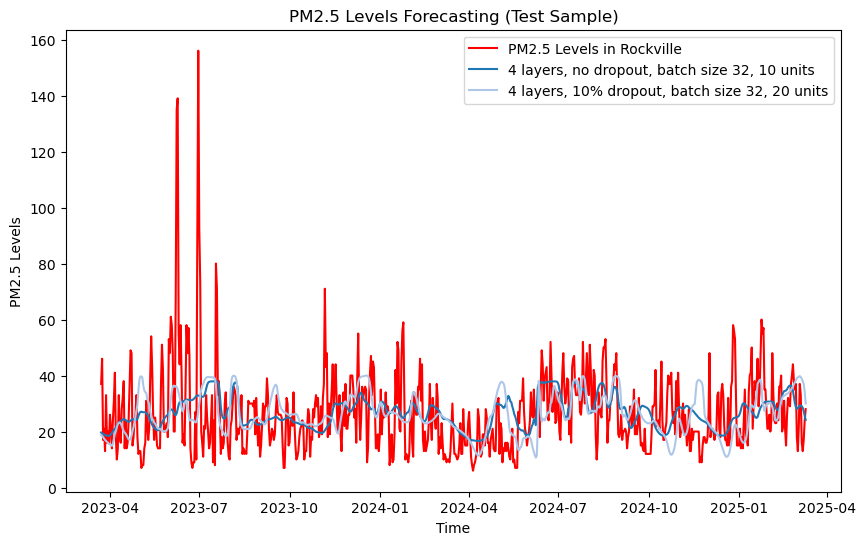

In [389]:
# Visualize test performance data
plt.figure(figsize=(10, 6))
plt.plot(test_df.tail(y_test.shape[0]).index, test_df.tail(y_test.shape[0])[target_col], color = 'red', label = 'PM2.5 Levels in Rockville')

for ii in range(len(models)):
    color = plt.cm.tab20(ii)
    model = models[ii]
    label = data_and_model_configs[ii]['label']
    y_test = data_dict['y_test']
    X_test = data_dict['X_test']
    plt.plot(test_df.tail(y_test.shape[0]).index, model.predict(X_test), # sc.inverse_transform(model.predict(X_test)), 
             color = color, label = label)
    
plt.title('PM2.5 Levels Forecasting (Test Sample)')
plt.xlabel('Time')
plt.ylabel('PM2.5 Levels')
plt.legend()
plt.show()

In [390]:
# Test set performance comparison, not moving the needle much
train_mses = []
test_mses = []
model_types = []
for ii in range(len(models)):
    model = models[ii]
    label = data_and_model_configs[ii]['label']
    train_mses.append(mean_squared_error(y_true = y_train, y_pred = model.predict(X_train)))
    test_mses.append(mean_squared_error(y_true = y_test, y_pred = model.predict(X_test)))
    model_types.append(label)
    print(label)

pd.DataFrame({'models': model_types, 'Train MSE': train_mses, 'Test MSE': test_mses})

23/23 [==============================] - 0s 4ms/step
4 layers, no dropout, batch size 32, 10 units
23/23 [==============================] - 0s 5ms/step
4 layers, 10% dropout, batch size 32, 20 units


,models,Train MSE,Test MSE
0,"4 layers, no dropout, batch size 32, 10 units",126.061158,205.620809
1,"4 layers, 10% dropout, batch size 32, 20 units",125.290117,227.262108


### Bidirectional LSTM with lagged features

In [401]:
def create_bidirectional_lstm_model(unit_list, dropout_rate_list, input_shape):

    # Check that both list are equal length
    assert isinstance(unit_list, list)
    assert isinstance(unit_list, list)
    assert len(unit_list) == len(dropout_rate_list)

    model = Sequential()
    for ii in range(len(unit_list)):

        dropout = dropout_rate_list[ii]
        unit = unit_list[ii]
        
        if ii == 0:
            model.add(Bidirectional(LSTM(units=unit, return_sequences=True, input_shape = input_shape)))
            #model.add(LSTM(units = unit, return_sequences = True, input_shape = input_shape))
            if dropout > 0:
                model.add(Dropout(dropout))

        # If we aren't on the last node, still use return sequences
        elif ii != len(unit_list)-1:
            model.add(Bidirectional(LSTM(units=unit, return_sequences=True)))
            #model.add(LSTM(units = unit, return_sequences = True))
            if dropout > 0:
                model.add(Dropout(dropout))

        else:
            model.add(Bidirectional(LSTM(units=unit)))
            #model.add(LSTM(units = unit))
            if dropout > 0:
                model.add(Dropout(dropout))

    # Add output layer
    model.add(Dense(units = 1, activation = 'linear'))

    return model

In [409]:
# Not going to test the number of epochs
epochs = 200

data_and_model_configs = [
    {'unit_list': [10] * 4, 'dropout_rate_list': [0] * 4, 'lags': [7, 14, 21], 'lookback': 60, 'batch_size': 32, 
         'loss': 'mean_squared_error', 'label': '4 layers, no dropout, batch size 32, 10 units'},
    {'unit_list': [15] * 4, 'dropout_rate_list': [.2] * 4, 'lags': [7, 14, 21], 'lookback': 60, 'batch_size': 32, 
         'loss': 'mean_squared_error', 'label': '4 layers, 20% dropout, batch size 32, 15 units'},
    {'unit_list': [10] * 5, 'dropout_rate_list': [.1] * 5, 'lags': [7, 14, 21], 'lookback': 60, 'batch_size': 32, 
         'loss': 'mean_squared_error', 'label': '5 layers, 10% dropout, batch size 32, 10 units'},
]

In [418]:
# Not going to test the number of epochs
epochs = 400

data_and_model_configs = [
    {'unit_list': [10] * 4, 'dropout_rate_list': [0] * 4, 'lags': [7, 14, 21], 'lookback': 60, 'batch_size': 32, 
         'loss': 'mean_squared_error', 'label': '4 layers, no dropout, batch size 32, 10 units'}
]

In [419]:
# Get model output (let's not play with lookback / lags in this)
models = []

for config in data_and_model_configs:

    lags = config['lags']
    lookback = config['lookback']
    unit_list = config['unit_list']
    dropout_rate_list = config['dropout_rate_list']
    batch_size = config['batch_size']
    loss = config['loss']
    
    # Get input shape to pass to LSTM object
    input_shape = (X_train.shape[1], X_train.shape[2])
    
    # Create and train lstm model
    model = create_bidirectional_lstm_model(unit_list, dropout_rate_list, input_shape)
    model, history = train_lstm_model(model, X_train, y_train, epochs, batch_size, loss)
    
    # Save model and data
    models.append(model)

Epoch 1/400
66/66 [==============================] - 6s 27ms/step - loss: 861.6632
Epoch 2/400
66/66 [==============================] - 2s 26ms/step - loss: 661.0084
Epoch 3/400
66/66 [==============================] - 1s 22ms/step - loss: 556.9284
Epoch 4/400
66/66 [==============================] - 1s 22ms/step - loss: 490.0181
Epoch 5/400
66/66 [==============================] - 2s 24ms/step - loss: 439.6342
Epoch 6/400
66/66 [==============================] - 1s 22ms/step - loss: 397.5175
Epoch 7/400
66/66 [==============================] - 1s 22ms/step - loss: 361.5685
Epoch 8/400
66/66 [==============================] - 1s 22ms/step - loss: 330.3774
Epoch 9/400
66/66 [==============================] - 1s 23ms/step - loss: 303.5417
Epoch 10/400
66/66 [==============================] - 2s 24ms/step - loss: 280.3434
Epoch 11/400
66/66 [==============================] - 2s 23ms/step - loss: 260.5137
Epoch 12/400
66/66 [==============================] - 1s 22ms/step - loss: 243.4356
E

23/23 [==============================] - 1s 4ms/step


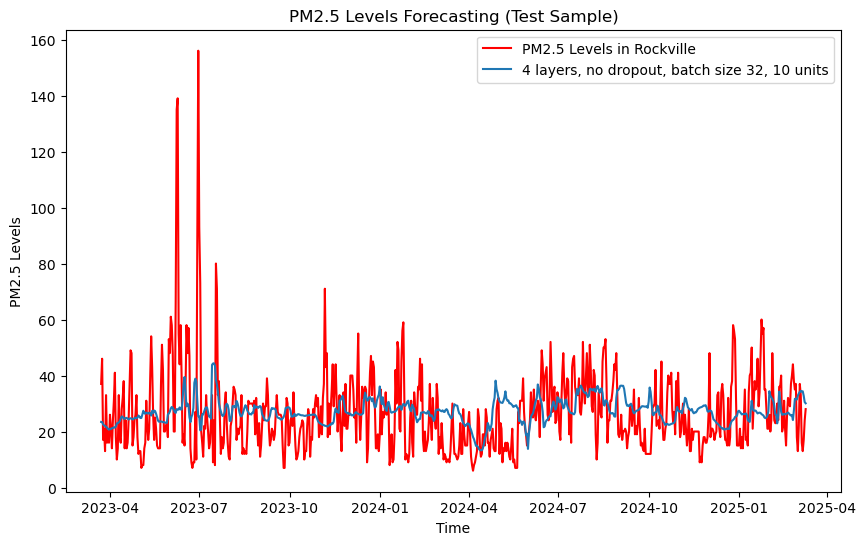

In [420]:
# Visualize test performance data
plt.figure(figsize=(10, 6))
plt.plot(test_df.tail(y_test.shape[0]).index, test_df.tail(y_test.shape[0])[target_col], color = 'red', label = 'PM2.5 Levels in Rockville')

for ii in range(len(models)):
    color = plt.cm.tab20(ii)
    model = models[ii]
    label = data_and_model_configs[ii]['label']
    y_test = data_dict['y_test']
    X_test = data_dict['X_test']
    plt.plot(test_df.tail(y_test.shape[0]).index, model.predict(X_test), # sc.inverse_transform(model.predict(X_test)), 
             color = color, label = label)
    
plt.title('PM2.5 Levels Forecasting (Test Sample)')
plt.xlabel('Time')
plt.ylabel('PM2.5 Levels')
plt.legend()
plt.show()

In [421]:
# Test set performance comparison, not moving the needle much
train_mses = []
test_mses = []
model_types = []
for ii in range(len(models)):
    model = models[ii]
    label = data_and_model_configs[ii]['label']
    train_mses.append(mean_squared_error(y_true = y_train, y_pred = model.predict(X_train)))
    test_mses.append(mean_squared_error(y_true = y_test, y_pred = model.predict(X_test)))
    model_types.append(label)
    print(label)

pd.DataFrame({'models': model_types, 'Train MSE': train_mses, 'Test MSE': test_mses})

23/23 [==============================] - 0s 4ms/step
4 layers, no dropout, batch size 32, 10 units


,models,Train MSE,Test MSE
0,"4 layers, no dropout, batch size 32, 10 units",129.359193,225.986652


### Bidirectional with early stopping